In [1]:
# note for team: download the dataset zip from kaggle
# create a folder in the same root folder as this file called "dataset"
# unzip the downloaded data in that dataset folder and everything else should work
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import randint, uniform


In [2]:
all_airlines = pd.read_csv("dataset/archive/Airlines.csv")
print(all_airlines.head())
print(all_airlines.describe())

  Code                    Description
0  02Q                  Titan Airways
1  04Q             Tradewind Aviation
2  05Q            Comlux Aviation, AG
3  06Q  Master Top Linhas Aereas Ltd.
4  07Q            Flair Airlines Ltd.
        Code    Description
count   1570           1571
unique  1570           1571
top      02Q  Titan Airways
freq       1              1


In [3]:
flight_data = pd.read_csv("dataset/archive/Combined_Flights_2021.csv")
print(flight_data.head())
print(flight_data.describe())

   FlightDate                Airline Origin Dest  Cancelled  Diverted  \
0  2021-03-03  SkyWest Airlines Inc.    SGU  PHX      False     False   
1  2021-03-03  SkyWest Airlines Inc.    PHX  SGU      False     False   
2  2021-03-03  SkyWest Airlines Inc.    MHT  ORD      False     False   
3  2021-03-03  SkyWest Airlines Inc.    DFW  TRI      False     False   
4  2021-03-03  SkyWest Airlines Inc.    PHX  BFL      False     False   

   CRSDepTime  DepTime  DepDelayMinutes  DepDelay  ...  WheelsOff  WheelsOn  \
0         724    714.0              0.0     -10.0  ...      724.0     813.0   
1         922    917.0              0.0      -5.0  ...      940.0    1028.0   
2        1330   1321.0              0.0      -9.0  ...     1336.0    1445.0   
3        1645   1636.0              0.0      -9.0  ...     1703.0    1955.0   
4        1844   1838.0              0.0      -6.0  ...     1851.0    1900.0   

   TaxiIn  CRSArrTime  ArrDelay  ArrDel15  ArrivalDelayGroups  ArrTimeBlk  \
0     5.0

In [4]:
missing_values_per_column = flight_data.isna().any(axis=0)
print(missing_values_per_column)

FlightDate            False
Airline               False
Origin                False
Dest                  False
Cancelled             False
                      ...  
ArrDel15               True
ArrivalDelayGroups     True
ArrTimeBlk            False
DistanceGroup         False
DivAirportLandings     True
Length: 61, dtype: bool


In [4]:
print(flight_data['Origin'].nunique())
print(flight_data['Dest'].nunique())

# There's 375 different airport codes which is too much to reliably encode. I found this dataset: https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv
# which gives you the geographic location (lon, lat) of each airport code. So we'll map the code to a geographic location. Add a file called "airport-codes" in the "archive" file
# add only the csv file or move it back one folder if you downloaded zip (should be /archive/airport-codes/iata-icao.csv)
airport_codes = pd.read_csv("dataset/archive/airport-codes/iata-icao.csv")
print(airport_codes.head())
airport_codes_indexed = airport_codes.set_index("iata")

# If it seems like it's taking forever or like something is broken, going to "Run" -> "Restart Kernel and Run All Cells" worked for me
mapping_dict_lat = airport_codes_indexed["latitude"].to_dict()
mapping_dict_lon = airport_codes_indexed["longitude"].to_dict()
flight_data["Origin_Lat"] = flight_data["Origin"].map(mapping_dict_lat)
flight_data["Origin_Lon"] = flight_data["Origin"].map(mapping_dict_lon)

flight_data["Dest_Lat"] = flight_data["Dest"].map(mapping_dict_lat)
flight_data["Dest_Lon"] = flight_data["Dest"].map(mapping_dict_lon)

print(flight_data.head())

# Add a column that gives us our target delay prediction time including the total delay (will be negative if early arrival)
flight_data["TotalDelay"] = flight_data["ActualElapsedTime"] - flight_data["CRSElapsedTime"]
print(flight_data["TotalDelay"].head())

# Replace any unknown delays with 0 - might want to improve this logic (there might be other info we can derive delay from for only the na values)
flight_data["TotalDelay"] = np.nan_to_num(flight_data["TotalDelay"])

380
380
  country_code region_name iata  icao                          airport  \
0           AE    Abu Zaby  AAN  OMAL     Al Ain International Airport   
1           AE    Abu Zaby  AUH  OMAA  Abu Dhabi International Airport   
2           AE    Abu Zaby  AYM   NaN         Yas Island Seaplane Base   
3           AE    Abu Zaby  AZI  OMAD      Al Bateen Executive Airport   
4           AE    Abu Zaby  DHF  OMAM               Al Dhafra Air Base   

   latitude  longitude  
0   24.2617    55.6092  
1   24.4330    54.6511  
2   24.4670    54.6103  
3   24.4283    54.4581  
4   24.2482    54.5477  
   FlightDate                Airline Origin Dest  Cancelled  Diverted  \
0  2021-03-03  SkyWest Airlines Inc.    SGU  PHX      False     False   
1  2021-03-03  SkyWest Airlines Inc.    PHX  SGU      False     False   
2  2021-03-03  SkyWest Airlines Inc.    MHT  ORD      False     False   
3  2021-03-03  SkyWest Airlines Inc.    DFW  TRI      False     False   
4  2021-03-03  SkyWest Airlines 

In [6]:
# normalize the weather delay column to 0-1 to match the normalized value on the website backend  (I
# basically just made the delay in minutes correspond to the severity of weather (clear skies, thunderstorm, etc.)

min_val = np.min(flight_data["TotalDelay"])
max_val = np.max(flight_data["TotalDelay"])

# Apply the min-max normalization formula
flight_data["DepDelay_Normalized"] = (flight_data["TotalDelay"] - min_val) / (max_val - min_val)

print("Normalized data:", flight_data["DepDelay_Normalized"].head())
print("DepDelay_Normalized:", np.unique(flight_data["DepDelay_Normalized"], return_counts=True))


Normalized data: 0    0.646937
1    0.654508
2    0.643496
3    0.657949
4    0.646249
Name: DepDelay_Normalized, dtype: float64
DepDelay_Normalized: (array([0.        , 0.10185822, 0.24913971, 0.39710943, 0.42188575,
       0.46317963, 0.46799725, 0.48657949, 0.52718513, 0.54026153,
       0.54163799, 0.54989677, 0.55402615, 0.55815554, 0.56710255,
       0.56985547, 0.5726084 , 0.5815554 , 0.58499656, 0.58774948,
       0.59119064, 0.59325533, 0.5946318 , 0.59532003, 0.59669649,
       0.59807295, 0.59876118, 0.59944942, 0.60013765, 0.60082588,
       0.60151411, 0.60220234, 0.60289057, 0.6035788 , 0.60426703,
       0.60495526, 0.6056435 , 0.60633173, 0.60701996, 0.60770819,
       0.60839642, 0.60908465, 0.60977288, 0.61046111, 0.61114935,
       0.61183758, 0.61252581, 0.61321404, 0.61390227, 0.6145905 ,
       0.61527873, 0.61596696, 0.6166552 , 0.61734343, 0.61803166,
       0.61871989, 0.61940812, 0.62009635, 0.62078458, 0.62147281,
       0.62216105, 0.62284928, 0.62353751, 0.

In [5]:
# Sampling and finding correlation
sampled_flight_data = flight_data.sample(frac=0.1, random_state=16)


numerical_cols = sampled_flight_data.select_dtypes(include=np.number).columns
correlation_matrix = sampled_flight_data[numerical_cols].corr()
total_delay_correlation = correlation_matrix['TotalDelay'].sort_values(ascending=False)

print("Correlation with TotalDelay (10% sample):")
print(total_delay_correlation)

Correlation with TotalDelay (10% sample):
TotalDelay                         1.000000
TaxiOut                            0.534689
ArrivalDelayGroups                 0.364158
TaxiIn                             0.349248
ArrDel15                           0.325336
ArrDelay                           0.274196
ArrDelayMinutes                    0.162057
DOT_ID_Marketing_Airline           0.082704
ActualElapsedTime                  0.080971
DOT_ID_Operating_Airline           0.079066
OriginWac                          0.030403
WheelsOn                           0.024850
Flight_Number_Operating_Airline    0.023779
Flight_Number_Marketing_Airline    0.023778
WheelsOff                          0.023013
ArrTime                            0.022692
OriginCityMarketID                 0.021575
DestStateFips                      0.020474
Month                              0.015470
DivAirportLandings                 0.014869
DepartureDelayGroups               0.014822
Quarter                           

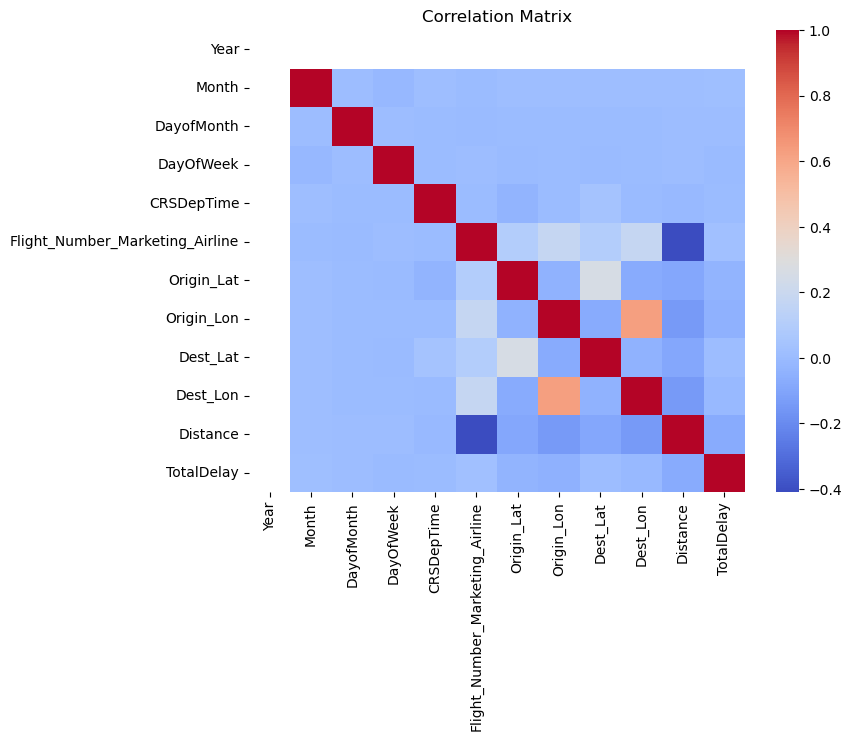

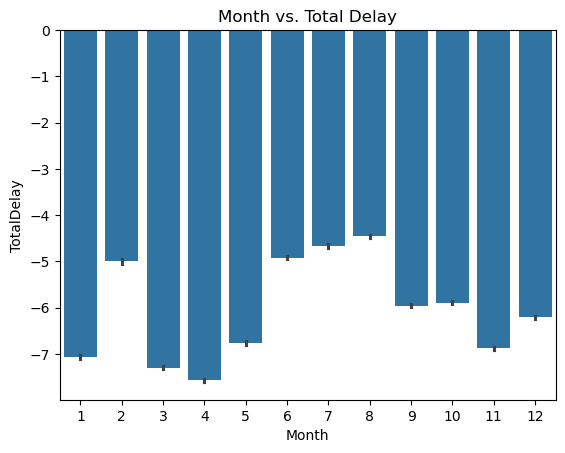

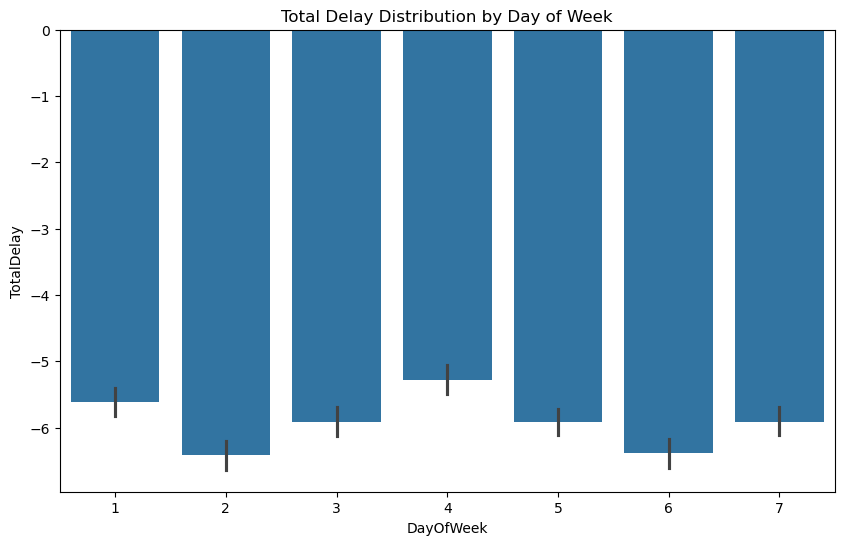

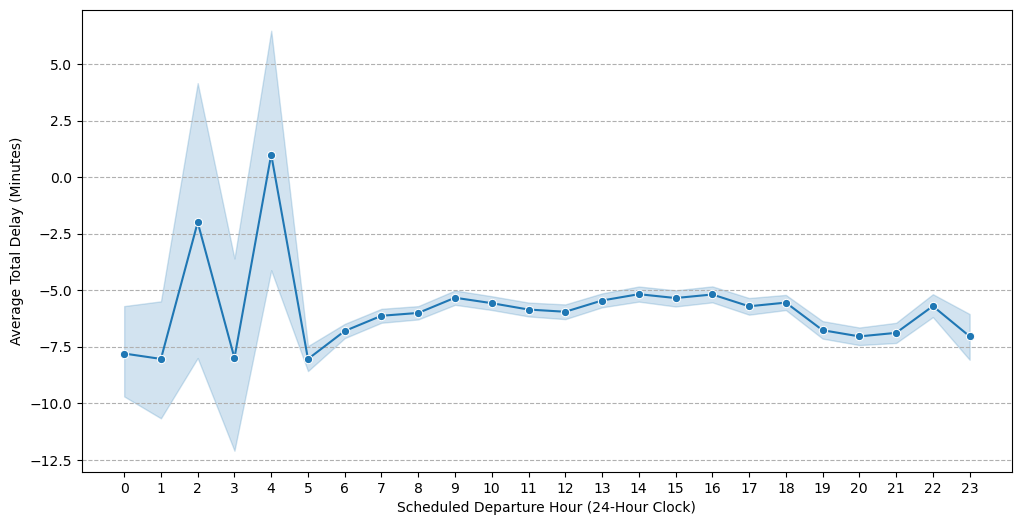

New DataFrame with selected columns:


,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,Flight_Number_Marketing_Airline,Origin_Lat,Origin_Lon,Dest_Lat,Dest_Lon,Distance,TotalDelay
0,2021,3,3,3,724,3133,37.0364,-113.5100,33.4343,-112.0120,262.0,-15.0
1,2021,3,3,3,922,3134,33.4343,-112.0120,37.0364,-113.5100,262.0,-4.0
2,2021,3,3,3,1330,3135,42.9326,-71.4357,41.9786,-87.9047,843.0,-20.0
3,2021,3,3,3,1645,3136,32.8968,-97.0380,36.4752,-82.4074,868.0,1.0
4,2021,3,3,3,1844,3137,33.4343,-112.0120,35.4336,-119.0570,425.0,-16.0


In [6]:
# The columns I (Hunter) chose to use for training, we can talk about changing this in future meetings
selected_columns = ['Year','Month','DayofMonth','DayOfWeek',
                    'CRSDepTime',
                    'Flight_Number_Marketing_Airline',
                    'Origin_Lat', 'Origin_Lon',
                    'Dest_Lat', 'Dest_Lon', 'Distance',
                    'TotalDelay']
filtered_flight_data = flight_data[selected_columns]

import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = filtered_flight_data.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

sns.barplot(x="Month", y="TotalDelay", data=filtered_flight_data)
plt.title("Month vs. Total Delay")
plt.show()

sampled_data = filtered_flight_data.sample(n=100000, random_state=42)
plt.figure(figsize=(10, 6))
sns.barplot(x="DayOfWeek", y="TotalDelay", data=sampled_data)
plt.title("Total Delay Distribution by Day of Week")
plt.show()

sampled_data['CRSDepHour'] = sampled_data['CRSDepTime'] // 100
plt.figure(figsize=(12, 6))
sns.lineplot(x="CRSDepHour", y="TotalDelay", data=sampled_data, marker='o')
plt.xlabel("Scheduled Departure Hour (24-Hour Clock)")
plt.ylabel("Average Total Delay (Minutes)")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')
plt.show()

print("New DataFrame with selected columns:")
display(filtered_flight_data.head())

In [8]:
# Makes pipeline that converts the time to a more applicable format

def convert_to_minutes(x):
  """Converts the hhmm format into minutes for CRSDepTime"""
  df = x.copy()
  column = 'CRSDepTime'

  hh = (df[column] // 100).astype(int)
  mm = (df[column] % 100).astype(int)
  df[column] = hh * 60 + mm
  return df

# These are the features that will be transformed

numeric_features = [
    'CRSDepTime',
    'Distance',
    'Origin_Lat',
    'Origin_Lon',
    'Dest_Lat',
    'Dest_Lon'
]

categorical_features = [
    'Flight_Number_Marketing_Airline',
    'DayOfWeek',
    'Month',
    'DayofMonth'
]

# Transformer for the time changing
time_converter = FunctionTransformer(convert_to_minutes)

# A series of transformers to scale and encode different types of data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Random Forest model pipeline
model = Pipeline(steps=[
    ('timeconvert', time_converter),
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=16))
])

# XGB model pipeline
model_xgb = Pipeline([
    ('timeconvert', time_converter),
    ('preprocess', preprocessor),
    ('xgb', XGBRegressor(
        n_estimators=1000,
        random_state=16,
        verbosity=0
    ))
])

# parm distribution for random search
param_distributions = {
    'xgb__max_depth': randint(3, 15),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4)
}

# random search to optimize parms of XGB pipeline
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=2,
    verbose=3,
    n_jobs=1,
    random_state=16
)

In [11]:
# Last step before training, just set up training, testing, and validation data.
# BEFORE TRAINING: Need to remove any unwanted x (input) columns and finish cleaning the data
sampled_filtered_flight_data = filtered_flight_data.sample(frac=0.1, random_state=16) # Sampling to make faster training to test if pipeline
y = sampled_filtered_flight_data["TotalDelay"]
X = sampled_filtered_flight_data.drop(columns=['TotalDelay'])

X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=16,
                                   test_size=0.2,
                                   shuffle=True)

split_index = len(y_test) // 2

print(f"Original test data length: {len(X_test)}")

X_test_new = X_test[:split_index]
y_test_new = y_test[:split_index]

X_validation = X_test[split_index:]
y_validation = y_test[split_index:]

print(f"Final test data length x: {len(X_test_new)}")
print(f"Final test data length y: {len(y_test_new)}")
print(f"Final validation data length x: {len(X_validation)}")
print(f"Final validation data length y: {len(y_validation)}")

Original test data length: 81567
Final test data length x: 40783
Final test data length y: 40783
Final validation data length x: 40784
Final validation data length y: 40784


In [ ]:
# Training of random forest model (Takes long time)
model.fit(X_train, y_train)

In [7]:
# Training of XGB model (Takes long time)
random_search.fit(X_train, y_train)

NameError: name 'random_search' is not defined

In [ ]:
# prediction testing for random forest
y_test_pred = model.predict(X_test_new)

print("Test MAE:", mean_absolute_error(y_test_new, y_test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_new, y_test_pred)))
print("Test R2:", r2_score(y_test_new, y_test_pred))

In [ ]:
# prediction testing for XGB
y_test_pred = random_search.predict(X_test_new)

print("Test MAE:", mean_absolute_error(y_test_new, y_test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_new, y_test_pred)))
print("Test R2:", r2_score(y_test_new, y_test_pred))